In [1]:
pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.4 MB 34 kB/s 
     |████████████████████████████████| 199 kB 31.1 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845512 sha256=b55aa41bafc54febb576dd642da8d7b089a7f5fdb434f0640da3142e08cd951b
  Stored in directory: /root/.cache/pip/wheels/43/dc/11/ec201cd671da62fa9c5cc77078235e40722170ceba231d7598
Successfully built pyspark


## Import the libraries

In [2]:
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import pyspark
from pyspark.sql import functions as F
from pyspark.sql import types
from pyspark.sql import SparkSession

from pyspark.ml.feature import Imputer, VectorAssembler, StringIndexer
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator


warnings.filterwarnings('ignore')

# Connect to Spark server

In [3]:
spark = pyspark.sql.SparkSession.builder.getOrCreate()

## Read the Dataset

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Read the dataset
path = '/content/drive/My Drive/Covid Data.csv'

data = spark.read.csv(path)

In [6]:
data

DataFrame[_c0: string, _c1: string, _c2: string, _c3: string, _c4: string, _c5: string, _c6: string, _c7: string, _c8: string, _c9: string, _c10: string, _c11: string, _c12: string, _c13: string, _c14: string, _c15: string, _c16: string, _c17: string, _c18: string, _c19: string, _c20: string]

## Read The columns

In [7]:
# read the columns and the datatype of each column
data = spark.read.csv(path,
                     sep=',',
                     inferSchema=True,
                     header=True,
                     multiLine=True)

data.printSchema()

root
 |-- USMER: integer (nullable = true)
 |-- MEDICAL_UNIT: integer (nullable = true)
 |-- SEX: integer (nullable = true)
 |-- PATIENT_TYPE: integer (nullable = true)
 |-- DATE_DIED: string (nullable = true)
 |-- INTUBED: integer (nullable = true)
 |-- PNEUMONIA: integer (nullable = true)
 |-- AGE: integer (nullable = true)
 |-- PREGNANT: integer (nullable = true)
 |-- DIABETES: integer (nullable = true)
 |-- COPD: integer (nullable = true)
 |-- ASTHMA: integer (nullable = true)
 |-- INMSUPR: integer (nullable = true)
 |-- HIPERTENSION: integer (nullable = true)
 |-- OTHER_DISEASE: integer (nullable = true)
 |-- CARDIOVASCULAR: integer (nullable = true)
 |-- OBESITY: integer (nullable = true)
 |-- RENAL_CHRONIC: integer (nullable = true)
 |-- TOBACCO: integer (nullable = true)
 |-- CLASIFFICATION_FINAL: integer (nullable = true)
 |-- ICU: integer (nullable = true)



## Data Preprocessing

In [8]:
#replace the value 1,2,3 by 1 and 4,5,6,7 by 0 (Values 1-3 mean that the patient was diagnosed with covid in different degrees, 
#4 or higher means that the patient is not a carrier of covid or that the test is inconclusive)
 
data = data.replace([1,2,3], 1, subset=['CLASIFFICATION_FINAL'])
data = data.replace([4,5,6,7], 0, subset=['CLASIFFICATION_FINAL'])

## Drop unnecessary columns

In [9]:
# drop un unnecessary columns 
drop_col = ['USMER', 'MEDICAL_UNIT','PATIENT_TYPE','DATE_DIED']

data = data.drop(*drop_col)

In [10]:
data.show()

+---+-------+---------+---+--------+--------+----+------+-------+------------+-------------+--------------+-------+-------------+-------+--------------------+---+
|SEX|INTUBED|PNEUMONIA|AGE|PREGNANT|DIABETES|COPD|ASTHMA|INMSUPR|HIPERTENSION|OTHER_DISEASE|CARDIOVASCULAR|OBESITY|RENAL_CHRONIC|TOBACCO|CLASIFFICATION_FINAL|ICU|
+---+-------+---------+---+--------+--------+----+------+-------+------------+-------------+--------------+-------+-------------+-------+--------------------+---+
|  1|     97|        1| 65|       2|       2|   2|     2|      2|           1|            2|             2|      2|            2|      2|                   1| 97|
|  2|     97|        1| 72|      97|       2|   2|     2|      2|           1|            2|             2|      1|            1|      2|                   0| 97|
|  2|      1|        2| 55|      97|       1|   2|     2|      2|           2|            2|             2|      2|            2|      2|                   1|  2|
|  1|     97|        2

## Cleaning Data

In [11]:
# check the null value

from pyspark.sql.functions import col,isnan, when, count
data.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in data.columns]
   ).show()

+---+-------+---------+---+--------+--------+----+------+-------+------------+-------------+--------------+-------+-------------+-------+--------------------+---+
|SEX|INTUBED|PNEUMONIA|AGE|PREGNANT|DIABETES|COPD|ASTHMA|INMSUPR|HIPERTENSION|OTHER_DISEASE|CARDIOVASCULAR|OBESITY|RENAL_CHRONIC|TOBACCO|CLASIFFICATION_FINAL|ICU|
+---+-------+---------+---+--------+--------+----+------+-------+------------+-------------+--------------+-------+-------------+-------+--------------------+---+
|  0|      0|        0|  0|       0|       0|   0|     0|      0|           0|            0|             0|      0|            0|      0|                   0|  0|
+---+-------+---------+---+--------+--------+----+------+-------+------------+-------------+--------------+-------+-------------+-------+--------------------+---+



#### we didn't have any null value . So we can go to the next step

# EDA

In [12]:
data.registerTempTable('data')

## First Plot

In [37]:
#select the column we need in EDA
df_result = spark.sql('SELECT CLASIFFICATION_FINAL, SEX, PREGNANT, INTUBED FROM data')

#convert to pandas prior to visualization
df_result = df_result.toPandas()

Text(0.5, 1.0, 'COUNT THE NUMBER OF INFECTED, NON-INFECTED')

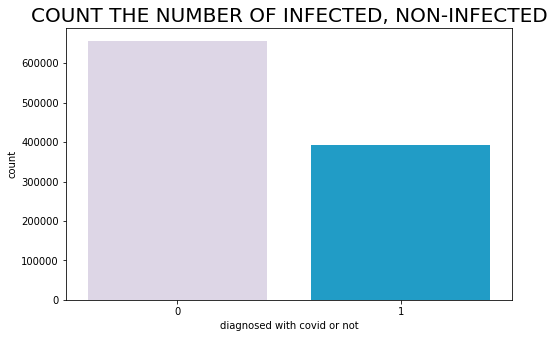

In [38]:
colors = ['#DDD3E9', '#06A9E1']
plt.figure(figsize = (8,5))
ax = sns.countplot(df_result.CLASIFFICATION_FINAL, palette=colors)

ax.set_xlabel('diagnosed with covid or not')
ax.set_ylabel('count')
plt.title("COUNT THE NUMBER OF INFECTED, NON-INFECTED", fontsize = 20)

###  The finding: in this plot want to count the classification final ( who the patient was diagnosed with covid or not ) we find  diagnosed with covid  with a value more than 350000 and others not diagnosed with a value more than 600000


## Second Plot

In [39]:
df_result = spark.sql('SELECT ASTHMA ,CLASIFFICATION_FINAL FROM data  WHERE CLASIFFICATION_FINAL IN ("1")')

#convert to pandas prior to visualization
df_result = df_result.toPandas()

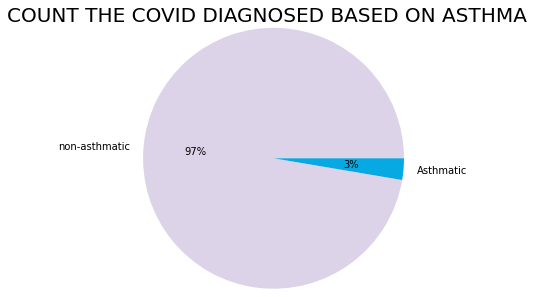

In [40]:
df_result_c = df_result['ASTHMA'].value_counts().nlargest(2)

plt.pie(df_result_c.values, labels= ['non-asthmatic', 'Asthmatic'], colors=colors, autopct='%.0f%%', textprops={'fontsize': 10},  radius=1.5)

plt.title("COUNT THE COVID DIAGNOSED BASED ON ASTHMA  ", fontsize = 20, y=1.1);
plt.show()

### the finding : want to calculate the percentage of whether the covid patient has asthma or not , based on this plot 97 % percentage don't have asthma and 3 % percentage have asthma


## Third Plot

In [41]:
df_result = spark.sql('SELECT CLASIFFICATION_FINAL, SEX FROM data')

#convert to pandas prior to visualization
df_result = df_result.toPandas()

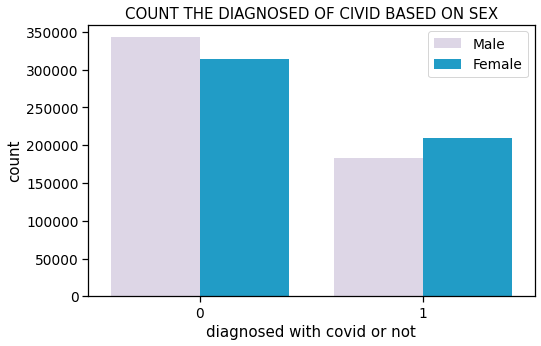

In [42]:
plt.figure(figsize = (8,5))
sns.set_context("notebook", font_scale=1.25)
gender = sns.countplot( x=df_result.CLASIFFICATION_FINAL, hue=df_result.SEX, palette=colors)
gender.set_title("COUNT THE DIAGNOSED OF CIVID BASED ON SEX", fontsize = 15)
gender.set_xlabel('diagnosed with covid or not')
gender.legend(["Male","Female"],loc='upper right')

### The finding: in this plot want to count the classification final ( who the patient was diagnosed with covid or not ) based on gender we find most diagnosed with covid are Famle

### Fourth Plot

In [43]:
#select the column we need in EDA
df_result = spark.sql('SELECT CLASIFFICATION_FINAL ,AGE  FROM data WHERE CLASIFFICATION_FINAL IN ("1") ')

#convert to pandas prior to visualization
df_result = df_result.toPandas()

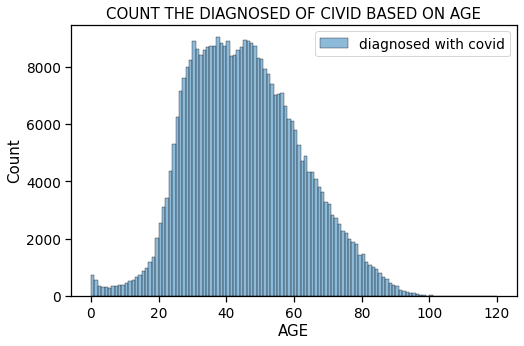

In [44]:
plt.figure(figsize = (8,5))
sns.set_context("notebook", font_scale=1.25)
age = sns.histplot(data=df_result, x='AGE', hue='CLASIFFICATION_FINAL', binwidth=1)
age.set_title("COUNT THE DIAGNOSED OF CIVID BASED ON AGE", fontsize = 15);
age.legend(['diagnosed with covid'],loc='upper right')

###  The finding: in this plot want to know the most ages get Coved, based on this plot most ages get coved between 30 and 55 years old.

##fifth plot

In [45]:
#select the column we need in EDA
df_result = spark.sql('SELECT tobacco,CLASIFFICATION_FINAL FROM data WHERE CLASIFFICATION_FINAL IN ("1")')

#convert to pandas prior to visualization
df_result = df_result.toPandas()

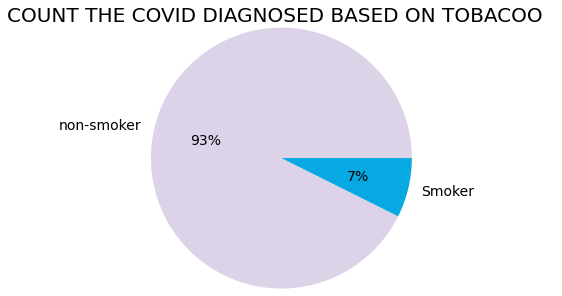

In [46]:
df_result_c = df_result['tobacco'].value_counts().nlargest(2)

plt.pie(df_result_c.values, labels=['non-smoker', 'Smoker'], colors=colors, autopct='%.0f%%', textprops={'fontsize': 14},  radius=1.5)
plt.title("COUNT THE COVID DIAGNOSED BASED ON TOBACOO  ", fontsize = 20,  y=1.1);
plt.show()

###  The finding: in this plot want to know the most ages get Coved, based on this plot most ages get coved between 30 and 55 years old.

## Data Processing 
No need for data processing all the data columns are numbers

## Building a Model

In [13]:
# Combining Feature Columns
cols = data.columns
cols.remove('CLASIFFICATION_FINAL') #remove CLASIFFICATION_FINAL -> we need this to be our label

assembler = VectorAssembler(inputCols=cols, outputCol='features')

data = assembler.transform(data)

In [14]:
# splitting data into training and testing sets 
df_data = data.select(F.col('features'), F.col('CLASIFFICATION_FINAL').alias('label'))

df_train, df_test = df_data.randomSplit([0.8, 0.2])

## Model Building

- Logistic Regression

In [15]:
from pyspark.ml.classification import LogisticRegression

# create the trainer and set its parameters
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)

# train the model
lrModel = lr.fit(df_train)

In [16]:
# Make predictions.
lrPreds = lrModel.transform(df_test)

- Decision Tree Classifier

In [17]:
from pyspark.ml.classification import DecisionTreeClassifier

# create the trainer and set its parameters
dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label', maxDepth = 3)

# train the model
dtModel = dt.fit(df_train)

In [18]:
# Make predictions.
dtPreds = dtModel.transform(df_test)

- Random Forest Classifier

In [19]:
from pyspark.ml.classification import RandomForestClassifier

# create the trainer and set its parameters
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label')

# train the model
rfModel = rf.fit(df_train)

In [20]:
# Make predictions.
rfPreds = rfModel.transform(df_test)

- Gradient-Boosted Tree Classifier

In [21]:
from pyspark.ml.classification import GBTClassifier

# create the trainer and set its parameters
gbt = GBTClassifier(maxIter=10)

# train the model
gbtModel = gbt.fit(df_train)

In [22]:
# Make predictions.
gbtPreds = gbtModel.transform(df_test)

- NaiveBayes

In [23]:
from pyspark.ml.classification import NaiveBayes

# create the trainer and set its parameters
naiv = NaiveBayes(smoothing=1.0, modelType="multinomial")

# train the model
naivModel = naiv.fit(df_train)

In [24]:
# Make predictions.
naivPreds = naivModel.transform(df_test)

- Multi layer Perceptron Classifier

In [25]:
from pyspark.ml.classification import MultilayerPerceptronClassifier

# specify layers for the neural network:
# input layer of size 16 (features), two intermediate of size 5 and 4
# and output of size 2 (classes)
layers = [16, 5, 4, 2]

# create the trainer and set its parameters
perce = MultilayerPerceptronClassifier(maxIter=100, layers=layers, blockSize=128, seed=1234)

# train the model
perceModel = perce.fit(df_train)

In [26]:
# Make predictions.
percePreds = perceModel.transform(df_test)

- Linear Support Vector Machine

In [32]:
from pyspark.ml.classification import LinearSVC

# create the trainer and set its parameters
lsvc = LinearSVC(maxIter=10, regParam=0.1)

# Fit the model
lsvcModel = lsvc.fit(df_train)

In [33]:
# Make predictions.
lsvcPreds = lsvcModel.transform(df_test)

## Model Evaluation 

In [27]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
# Accuracy Metric
evaluator_A = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")

# F1 Metric
evaluator_F = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")

# Weighted Precision
evaluator_P = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision")

# Weighted Recall
evaluator_R = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall")

In [34]:
# Our models
models = [lrPreds, dtPreds, rfPreds, gbtPreds, naivPreds, percePreds, lsvcPreds] 

# Empty lists that will store the scores for each metric for each model.
accuracy = []
F1 = []
precision = []
recall = []

# Simple loop to populate the empty lists with scores of models for each metric.
for model in models:
    accuracy.append(evaluator_A.evaluate(model))
    F1.append(evaluator_F.evaluate(model))
    precision.append(evaluator_P.evaluate(model))
    recall.append(evaluator_R.evaluate(model))

In [35]:
# We will convert all lists created above into a dataframe for easy viewing.

df_ev = pd.DataFrame(list(zip(accuracy, F1, precision, recall)), 
                     columns = ['Accuracy', 'F1 score', 'Weighted Precision', 'Weighted Recall'],
                     index = ['logistic regression','Decision Tree','Random Forest','Gradient-Boosted Tree','Naive Bayes','Multi layer Perceptron', 'Linear SVM']) 

In [36]:
df_ev

,Accuracy,F1 score,Weighted Precision,Weighted Recall
logistic regression,0.662001,0.619186,0.648449,0.662001
Decision Tree,0.661143,0.605417,0.653502,0.661143
Random Forest,0.665060,0.617971,0.655393,0.665060
Gradient-Boosted Tree,0.668371,0.626107,0.658353,0.668371
Naive Bayes,0.566724,0.573709,0.603820,0.566724
Multi layer Perceptron,0.662803,0.615668,0.651573,0.662803
Linear SVM,0.652473,0.616382,0.633081,0.652473


## Model Selection

- #### Our data is not balanced, so in choosing the best model, we must focus on the F1 score. Gradient-Boosted Tree has the highest F1 (0.626283), We chose it as the best model.

## we will try tuning Gradient-Boosted Tree model with the ParamGridBuilder and the CrossValidator

In [ ]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

paramGrid = (ParamGridBuilder()
             .addGrid(gbt.maxDepth, [2, 10])
             .addGrid(gbt.maxBins, [20, 30])
             .addGrid(gbt.maxIter, [10, 20])
             .build())

cv = CrossValidator(estimator=gbt, estimatorParamMaps=paramGrid, evaluator=evaluator_F, numFolds=5)

# Run cross validations.  
# This can take some minutes since it is training over many trees!
cvModel = cv.fit(df_train)
cvPreds = cvModel.transform(df_test)
evaluator_F.evaluate(cvPreds)

0.6258819211953449